In [79]:
# Code to make a fisher optimised grating
# Diffraction orders will constrain zernikes such that central airy disk 
# has greatest precision

# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

from pathlib import Path

In [123]:
wf_npix = 256 
diameter = 0.125 # This is default of toliman optical system. Can change.

wavelength = 585e-9

# This is to what degree we undersample Nyquist
nyquist_factor = 1
psf_npix = 256 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

# Place the source in the centre of the top right from center pixel.
# That's what the position argument does here
source = dl.PointSource(np.array([wavelength]),flux=1000000)

climb_basis = np.load("../xk4/files/basis.npy")

key = jr.PRNGKey(6)
coefficients = (100)*jr.normal(key, [len(climb_basis)])

mean_wl = source.wavelengths.mean()

# have to make sure that mean_wl is in meters.
mask_layer = ApplyBasisCLIMB(climb_basis, mean_wl, coefficients)

# Construct instrument
optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix, mask=mask_layer,
                            radial_orders=[2, 3], psf_pixel_scale=psf_pixel_scale, oversample=oversample)

model = dl.Telescope(optics, source)

In [124]:
# Marginal params
marginal_params = ['position', 'flux', 'aperture.coefficients']

# Loss function
opt_params = ['pupil.coefficients']
@zdx.filter_jit
@zdx.filter_value_and_grad(opt_params)

def fim_loss_func(model, parameters):
        
    data = model.model()

    cov = zdx.covariance_matrix(model, parameters, poiss_loglike, data=data)

    # loss = np.log10(cov[0,0]+cov[1,1])
    loss = (zdx.calc_entropy(cov))
    #loss = np.log10(cov[2,2])
    # loss = np.log10(np.trace(cov))
    #loss = np.log10(np.linalg.det(cov))
    
    return loss

955448.6422003635


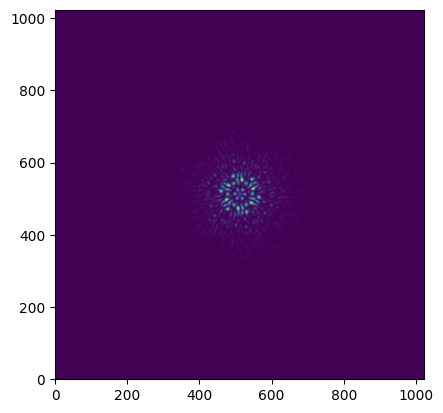

In [125]:
plt.imshow(model.model())
print(np.sum(model.model()))

In [126]:
optim, opt_state = zdx.get_optimiser(model, opt_params, optax.adam(2e1))

losses, models_out = [], [model]
with tqdm(range(100), desc='Gradient Descent') as t:
    for i in t:
        loss, grads = fim_loss_func(model, marginal_params)
        updates, opt_state = optim.update(grads, opt_state)   # your zdx API
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.6f}".format(float(loss)))

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [127]:
from copy import deepcopy

def strip_layer(optics, layer_name="pupil"):
    # Get items in a uniform way
    if isinstance(optics.layers, dict):
        items = list(optics.layers.items())
    else:
        items = list(optics.layers)  # already list of (name, layer)

    # Build the new layers as a list of (name, layer) tuples
    new_layers = []
    for name, layer in items:
        if name == layer_name:
            continue
        # must be (str, OpticalLayer) — not strings, not names only
        new_layers.append((name, deepcopy(layer)))

    # Construct a plain AngularOpticalSystem with the pupil removed
    return dl.AngularOpticalSystem(
        wf_npixels      = optics.wf_npixels,
        diameter        = optics.diameter,
        layers          = new_layers,              # <-- list of (name, OpticalLayer)
        psf_npixels     = optics.psf_npixels,
        oversample      = optics.oversample,
        psf_pixel_scale = optics.psf_pixel_scale,
    )

central_optics = strip_layer(model.optics, "pupil")
model_ng = dl.Telescope(
    optics = central_optics,
    source = source
)

data_ng = model_ng.model()
cov_ng = zdx.covariance_matrix(model_ng, marginal_params, poiss_loglike, data=data_ng)

data_final = models_out[-1].model()
cov = zdx.covariance_matrix(models_out[-1], marginal_params, poiss_loglike, data=data_final)

data_init = models_out[0].model()
cov_init = zdx.covariance_matrix(models_out[0], marginal_params, poiss_loglike, data=data_init)

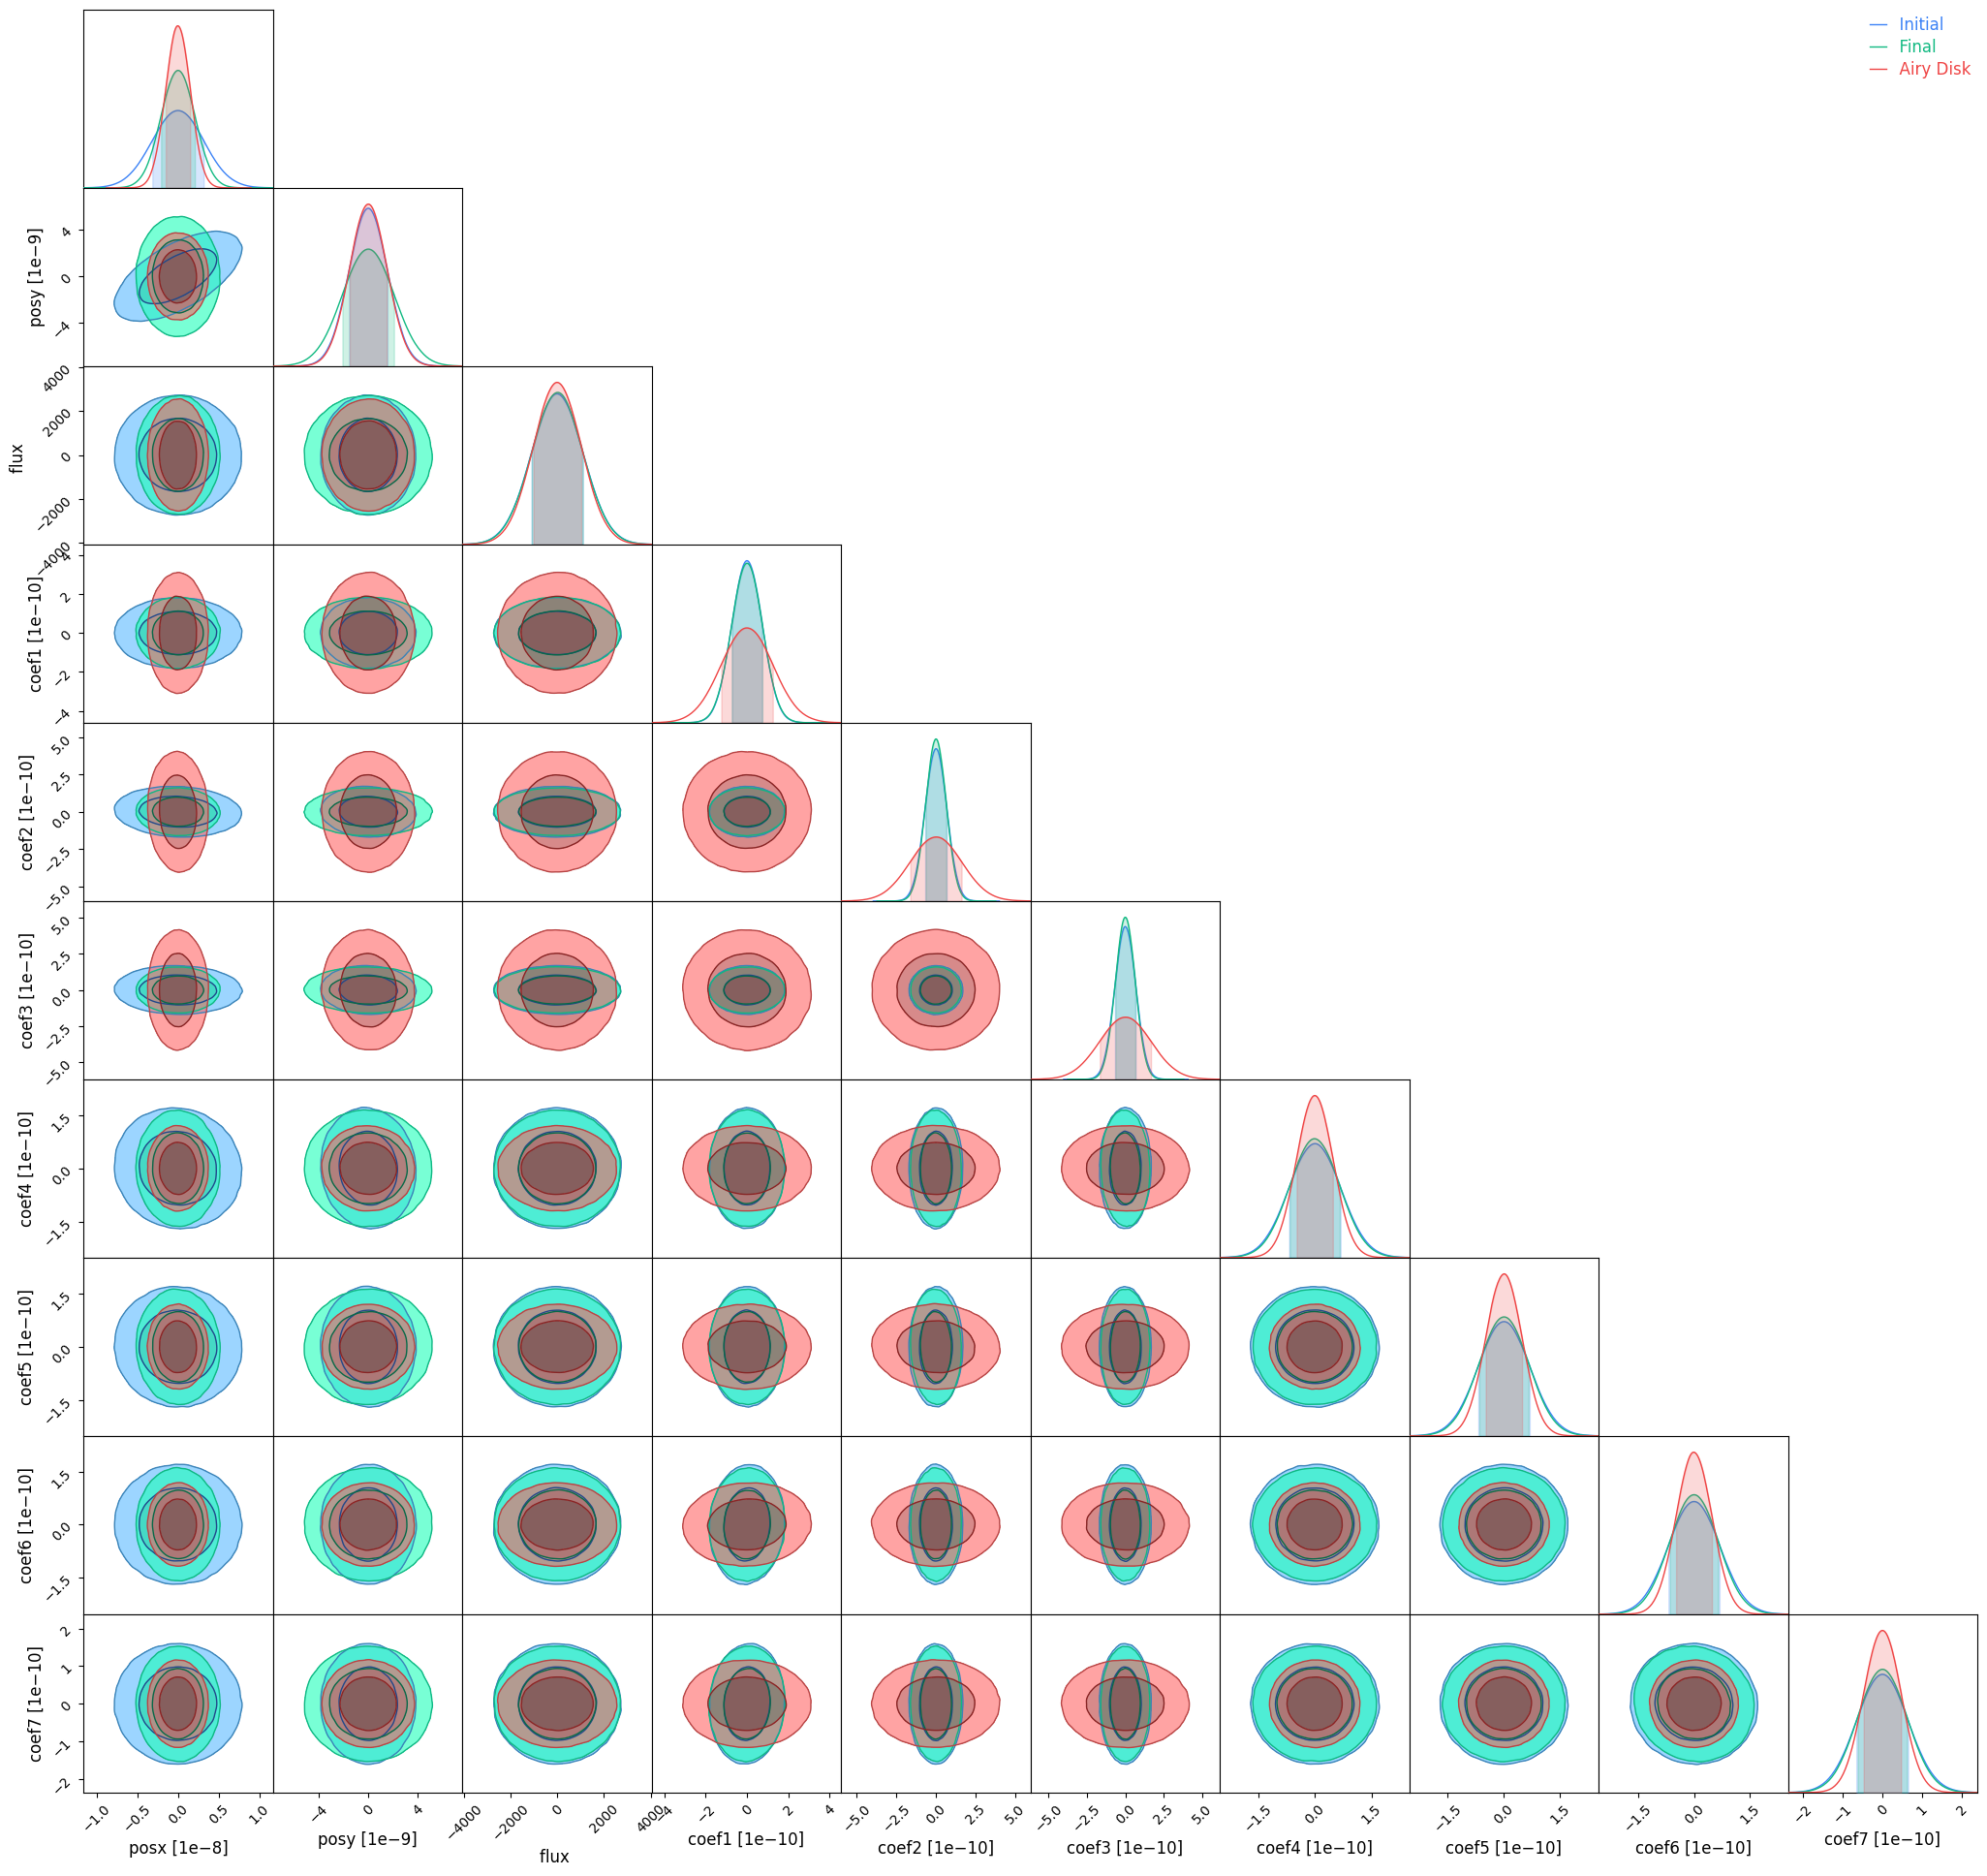

In [128]:
from chainconsumer import ChainConsumer, Chain
param_names = ["posx", "posy", "flux", "coef1", "coef2", "coef3", "coef4", "coef5", "coef6", "coef7"]
X = np.zeros(len(param_names))

c = ChainConsumer()
# This 'commented out' one is just before optimisation
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=dlu.rad2arcsec(covs[0]), columns=param_names, name="Initial")
# )

# To convert to arcsec, have to square the conversion factor
cov_to_arcsec = 1# dlu.rad2arcsec(1)**2
c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_init*cov_to_arcsec, columns=param_names, name='Initial')
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov*cov_to_arcsec, columns=param_names, name="Final")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_ng*cov_to_arcsec, columns=param_names, name='Airy Disk')
)


#c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()
# this is so whack I don't know what's going on
# why is the airy disk just a better wavefront sensor than a fisher optimised pupil
# this totally throws everything out the window
# the only victory to be had with fisher optimised pupils is separation marginalised over a lot of other things?
# it seems so... wrong.

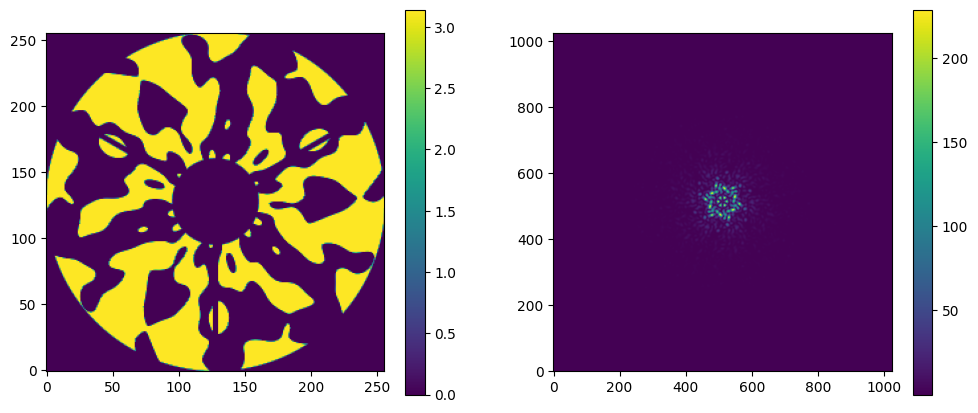

In [129]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(models_out[-1].get_binary_phase()*models_out[-1].aperture.transmission)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(models_out[-1].model())
plt.colorbar()
plt.show()

In [130]:
np.sum(data_ng)

Array(997462.92653374, dtype=float64)

In [131]:
np.sum(models_out[-1].model())

Array(960568.1060059, dtype=float64)

In [132]:
print(models_out[-1])

Telescope(
  optics=TolimanOpticalSystem(
    wf_npixels=256,
    diameter=0.125,
    layers={
      'aperture':
      BasisOptic(
        basis=f64[7,256,256],
        coefficients=f64[7],
        as_phase=False,
        transmission=f64[256,256],
        normalise=True
      ),
      'pupil':
      ApplyBasisCLIMB(
        basis=f64[100,768,768],
        coefficients=f64[100],
        as_phase=False,
        ideal_wavelength=f64[]
      )
    },
    psf_npixels=256,
    oversample=4,
    psf_pixel_scale=0.48265964661820554
  ),
  source=PointSource(
    spectrum=Spectrum(wavelengths=f64[1], weights=f64[1]),
    position=f64[2],
    flux=1000000.0
  ),
  detector=None
)


In [133]:
print(np.sqrt(cov_ng[2,2]))

1016.7918711062455


In [134]:
np.sqrt(zdx.covariance_matrix(model_ng, 'flux', poiss_loglike, data=data_ng))

Array([[1016.79187111]], dtype=float64)

In [135]:
np.sqrt(1000000)

Array(1000., dtype=float64, weak_type=True)

In [136]:
0.318*wavelength/diameter

1.48824e-06

In [105]:
print(model_ng)

Telescope(
  optics=AngularOpticalSystem(
    wf_npixels=256,
    diameter=0.125,
    layers={
      'aperture':
      BasisOptic(
        basis=f64[7,256,256],
        coefficients=f64[7],
        as_phase=False,
        transmission=f64[256,256],
        normalise=True
      )
    },
    psf_npixels=256,
    oversample=4,
    psf_pixel_scale=0.48265964661820554
  ),
  source=PointSource(
    spectrum=Spectrum(wavelengths=f64[1], weights=f64[1]),
    position=f64[2],
    flux=1.0
  ),
  detector=None
)
